In [112]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [298]:
df = pd.read_csv('data/train_processed.csv')

In [299]:
# Normalize the features

feats = list(set(df.columns) - set(['logSalePrice', 'SalePrice']))
df_normalized[feats] = (df[feats] - df[feats].mean()) / df[feats].std()
df_normalized['logSalePrice'] = df['logSalePrice']
df_normalized['SalePrice'] = df['SalePrice'] / 1000000  # convert the unit to millions

In [343]:
def train_and_predict(
    df, feats, target, is_log_transformed=True,
    alphas=10 ** np.arange(-3.5, -2.8, 0.01)
):
    
    # Train-test split. Use 30% as testing data
    X_train, X_test, y_train, y_test = train_test_split(
        df[feats], df[target], test_size=0.3, random_state=1000)

    # Lasso cross-validation
    lasso_cv = LassoCV(cv=10, random_state=208, alphas=alphas)
    lasso_cv.fit(X_train, y_train)

    # Create a data frame to store how MSE changes with alpha (regularization strength)
    mse_path_df = pd.DataFrame({
        'alpha': lasso_cv.alphas_,
        'mse': np.mean(lasso_cv.mse_path_, axis=1)
    })

    # Predict on test data
    pred_test = lasso_cv.predict(X_test)
    
    # If log transform is used, we transform the data back to the original unit
    if is_log_transformed:
        pred_test = np.exp(pred_test) / 1000000  # in million dollar
        y_test = np.exp(y_test) / 1000000  # in million dollar
    
    # Calculate RMSE and MAPE
    rmse = np.sqrt(np.mean(np.square(pred_test - y_test)))
    mape = np.mean(np.abs(pred_test - y_test) / y_test)
    
    return {
        'mse_path': mse_path_df,
        'pred_test': pred_test,
        'X_test': X_test,  # return X_test for debugging purpose
        'y_test': y_test,
        'rmse': rmse,
        'mape': mape,
        'lasso_cv': lasso_cv  # store the whole lasso_cv object for easier exploration later
    }

In [372]:
def plot_results(res):
    plt.figure(figsize=(10, 7))
    
    # Scatter plot of the prediction
    plt.subplot(221)
    plt.plot(res['pred_test'], res['y_test'], '.')
    plt.xlabel('Predicted Sale Price')
    plt.ylabel('True Sale Price')
    
    # use get_xlim for both x and y to draw "x=y" line
    plt.plot(plt.gca().get_xlim(), plt.gca().get_xlim())
    
    # Residual plot
    plt.subplot(222)
    plt.plot(res['pred_test'], res['y_test'] - res['pred_test'], '.')
    plt.xlabel('Predicted Sale Price')
    plt.ylabel('Residual')
    
    # plot a horizontal line
    plt.plot(plt.gca().get_xlim(), [0, 0])

    # LASSO: mse vs penalty strength
    plt.subplot(212)
    plt.plot(res['mse_path']['alpha'], res['mse_path']['mse'], '.-')
    plt.xlabel('Penalty Strength')
    plt.ylabel('MSE')
    plt.grid()
    print('Test RMSE: {:.3f} million, or {:.2f}k'.format(res['rmse'], res['rmse'] * 1000))
    print('Test MAPE: {:.2%}'.format(res['mape']))
    

## Use log price as the target

In [345]:
res = train_and_predict(df_normalized, feats, 'logSalePrice', is_log_transformed=True)

/home/ye/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030735968134788294, tolerance: 0.014648014248096386
  model = cd_fast.enet_coordinate_descent_gram(
/home/ye/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030214087955227953, tolerance: 0.014648014248096386
  model = cd_fast.enet_coordinate_descent_gram(
/home/ye/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.351e-02, tolerance: 1.603e-02
  model = cd_fast.enet_coordinate_descent(


Test RMSE: 0.034 million, or 34.32k
Test MAPE: 10.53%


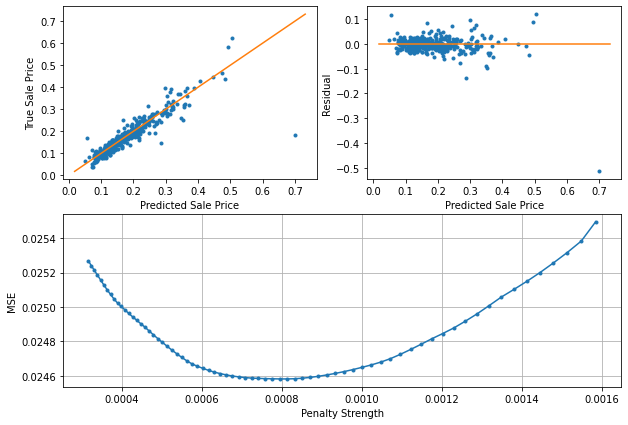

In [373]:
plot_results(res)

## Use price directly as the target

In [347]:
res2 = train_and_predict(df_normalized, feats, 'SalePrice', is_log_transformed=False,
                         alphas=10 ** np.arange(-4, -2, 0.01))

Test RMSE: 0.035 million, or 35.18k
Test MAPE: 13.19%


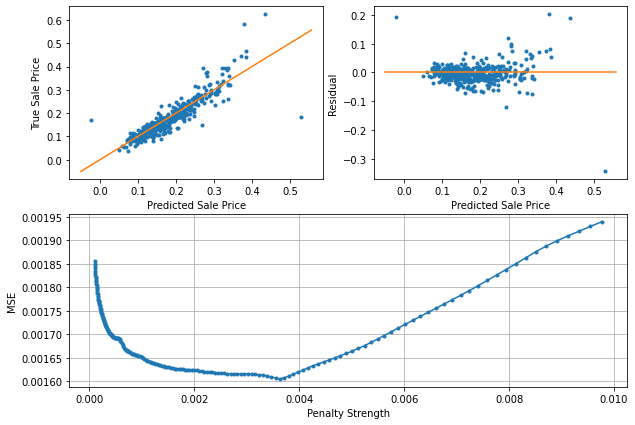

In [374]:
plot_results(res2)

In [379]:
feat_coef_df = pd.DataFrame({
    'feat_name': res['lasso_cv'].feature_names_in_,
    'coef': res['lasso_cv'].coef_
})